In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import coolbox
from coolbox.api import *
import pickle

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

import statsmodels
import random
import torch
import sys
sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from sklearn.cluster import KMeans
from CHARMtools import regression
import CHARMtools

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

from matplotlib import gridspec

set_all_seeds(42)
from sklearn.decomposition import PCA
from statannotations.Annotator import Annotator
from joblib import Parallel, delayed
import tqdm

In [2]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

## Load data

In [3]:
metadata = pd.read_csv("./brain.metadata.tsv",sep="\t",header = None)
metadata.columns = ["cellname","celltype","mc_15","mc_20","mc_30"]

with open("brain.pkl", "rb") as f:
    brain = pickle.load(f)
cells = list(brain.cells_dict.values())

rnamat = pd.read_csv("./brain.rna.tsv.gz",sep="\t").set_index("gene")
rnamat = rnamat.div(rnamat.sum(axis=0), axis=1) * 1e4
rnamat = np.log2(rnamat + 1)

In [4]:
data_filter_distance = pd.read_table("./CHARM_cor_filter_distance.tsv.gz")

In [5]:
genes = pd.read_csv("./transcripts.bed",sep="\t",header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["start"] = genes["start"] // 5000 * 5000
genes["end"] = genes["end"] // 5000 * 5000 + 5000
variable_genes = pd.read_csv("./brain.top5k.variablegenes.tsv",header=None).values.T.astype(str)[0]
variable_genes = pd.read_csv("./brain.top5k.variablegenes.tsv",header=None).values.T.astype(str)[0][:2000]
tss = pd.read_csv("./tss.bed",sep="\t",header=None)
tss.columns = ["chrom","start","end","gene","strand"]
tss["genome_coord"] =  tss.apply(lambda x: f"{x['chrom']}:{x['start']//5000*5000-int(2e6)}-{x['start']//5000*5000+5000+int(2e6)}", axis=1)
tss = tss.query('chrom != "chrM"')[["gene","genome_coord"]].drop_duplicates().reset_index(drop=True)
tss["tss_id"] = tss["gene"] + "_" + (tss.groupby("gene").cumcount() + 1).astype(str)

## Regression example

In [6]:
def _load_regression_data(gene):
    bins_considered = data_filter_distance.query('gene == @gene').query('obsexp_distance_fdr < 0.05 or atac_fdr < 0.05 or ct_fdr < 0.05')[["chrom","pos"]].copy().reset_index(drop=True)

    concat_df_mean = pd.read_csv(f"./data/{gene}.tsv.gz",sep="\t")

    atac_matrix = concat_df_mean[['chrom','pos','cellname','atac']].pivot_table(index=['chrom','pos'],columns='cellname',values='atac').fillna(0)
    ct_matrix = concat_df_mean[['chrom','pos','cellname','ct']].pivot_table(index=['chrom','pos'],columns='cellname',values='ct').fillna(0)
    obsexp_contact_matrix = concat_df_mean[['chrom','pos','cellname','obsexp_contact']].pivot_table(index=['chrom','pos'],columns='cellname',values='obsexp_contact').fillna(0)

    atac_matrix = atac_matrix.loc[bins_considered.set_index(["chrom","pos"]).index,metadata["cellname"].values]
    ct_matrix = ct_matrix.loc[bins_considered.set_index(["chrom","pos"]).index,metadata["cellname"].values]
    obsexp_contact_matrix = obsexp_contact_matrix.loc[bins_considered.set_index(["chrom","pos"]).index,metadata["cellname"].values]

    atac_matrix_norm = atac_matrix 
    ct_matrix_norm = ct_matrix 

    # minmax normalization on each row
    atac_matrix_norm = atac_matrix_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    ct_matrix_norm = ct_matrix_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    obsexp_contact_matrix_norm = obsexp_contact_matrix.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

    # na to 0
    atac_matrix_norm = atac_matrix_norm.fillna(0)
    ct_matrix_norm = ct_matrix_norm.fillna(0)
    obsexp_contact_matrix_norm = obsexp_contact_matrix_norm.fillna(0)

    atac_features = atac_matrix_norm.T   
    ct_features = ct_matrix_norm.T   
    contact_features = obsexp_contact_matrix_norm.T  
    X = np.hstack([atac_features, ct_features, contact_features])
    y = rnamat.loc[gene, metadata["cellname"].values].values
    y = (y - np.min(y)) / (np.max(y) - np.min(y)) * 100

    return X, y, bins_considered

In [7]:
gene = "Satb2"

regressor = regression.GeneRegressor(alpha=0.1, patience=20, norm_type="l2")
X, y, bins_considered = _load_regression_data(gene)
model, results = regressor.train_test_model(X= X, y=y, epochs=1000, test_size=0.2, lr=1e-3, batch_size=16, patience=20,celltype=metadata["celltype"].values)
shap_lst,shap_d = regression.set_gene_tile_significance_bootstrapped(X, y, model.linear.weight.data.numpy(), model.linear.bias.data.numpy(), metadata, "celltype", metadata["celltype"].unique())
atac_shap = pd.DataFrame(shap_d).T.iloc[:,:bins_considered.shape[0]]
atac_shap.columns = bins_considered["pos"].values
ct_shap = pd.DataFrame(shap_d).T.iloc[:,bins_considered.shape[0]:2*bins_considered.shape[0]]
ct_shap.columns = bins_considered["pos"].values
contact_shap = pd.DataFrame(shap_d).T.iloc[:,2*bins_considered.shape[0]:]
contact_shap.columns = bins_considered["pos"].values

total_shap = atac_shap + ct_shap + contact_shap

start_pos = bins_considered["pos"].min()
end_pos = bins_considered["pos"].max()

total_shap_zeros = pd.DataFrame(np.zeros((total_shap.shape[0],(end_pos-start_pos)//5000+1)))
total_shap_zeros.columns = np.arange(start_pos,end_pos+1,5000)
total_shap_zeros.index = total_shap.index

total_shap = total_shap_zeros + total_shap
total_shap = total_shap.fillna(0)

In [8]:
feature_length = bins_considered.shape[0]
bins_considered["atac_weight"] = model.linear.weight[0][:bins_considered.shape[0]].detach().numpy()
bins_considered["ct_weight"] = model.linear.weight[0][bins_considered.shape[0]:2*bins_considered.shape[0]].detach().numpy()
bins_considered["contact_weight"] = model.linear.weight[0][2*bins_considered.shape[0]:].detach().numpy()

pdata = bins_considered.copy()
min_pos = pdata["pos"].min()
max_pos = pdata["pos"].max()
pdata = pdata.set_index("pos").reindex(np.arange(min_pos, max_pos + 5000, 5000)).reset_index()
pdata = pdata.fillna(0)

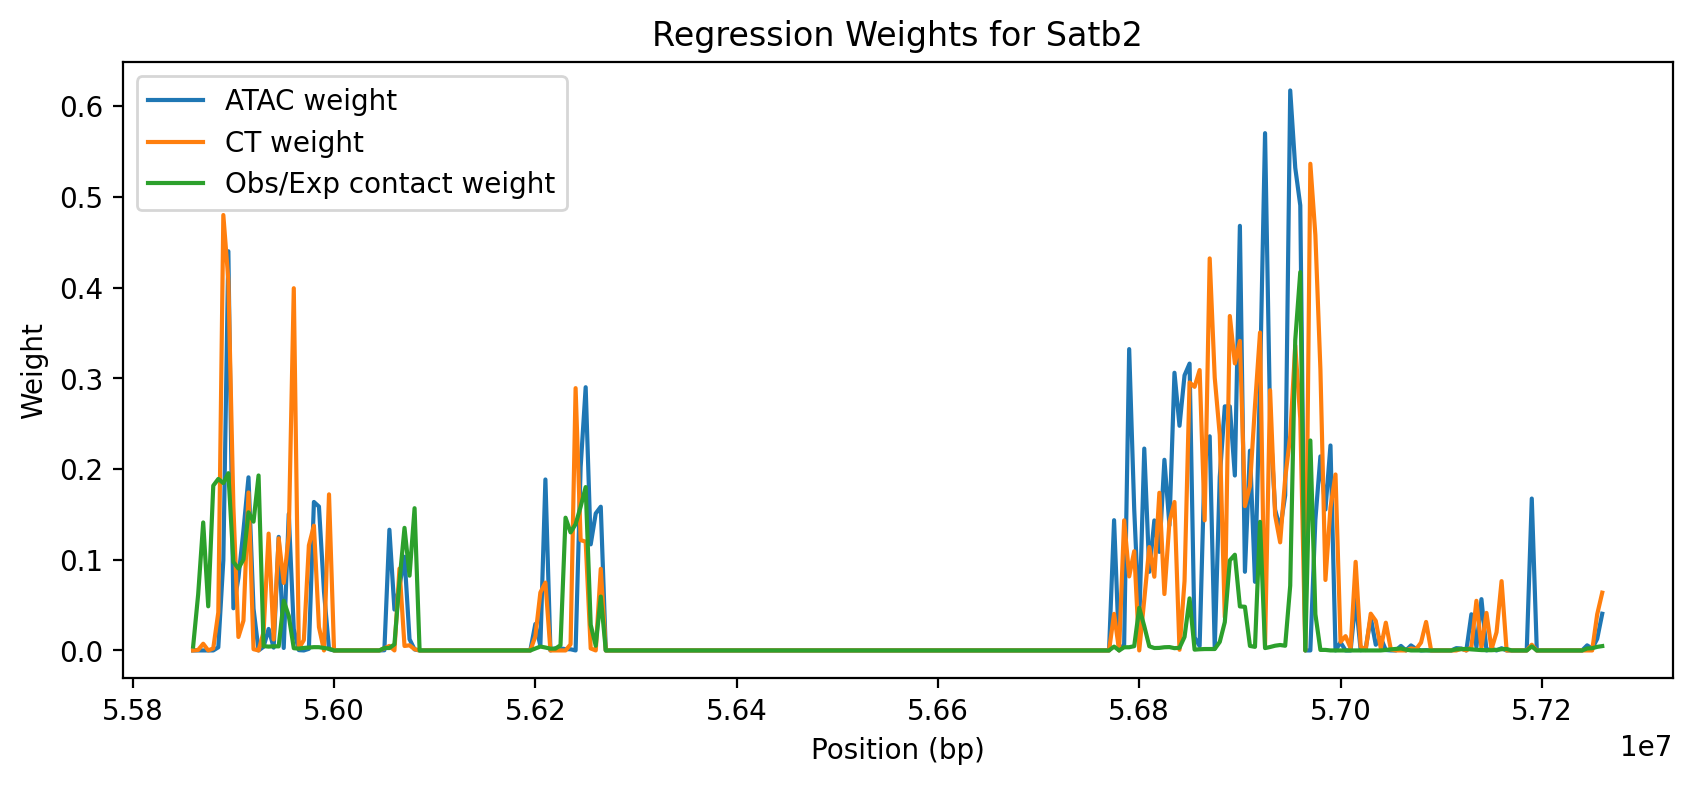

In [9]:
fig = plt.figure(figsize=(10, 4))
plt.plot(pdata["pos"], pdata["atac_weight"], label="ATAC weight")
plt.plot(pdata["pos"], pdata["ct_weight"], label="CT weight")
plt.plot(pdata["pos"], pdata["contact_weight"], label="Obs/Exp contact weight")

plt.xlabel("Position (bp)")
plt.ylabel("Weight")
plt.title(f"Regression Weights for {gene}")
plt.legend()

In [10]:
color_dict = {
    'Ex_OB': '#FC9576',
    'Ex_L2/3_IT': '#FB7858',
    'Ex_L3/4_IT': '#F6583F',
    'Ex_L5/6_IT': '#EB372A',
    'Ex_L5/6_NP': '#D11E1F',
    'Ex_L6_CT': '#B61318',
    'Ex_CL': '#940A12',
    'Inh_Pvalb': '#93C4DE',
    'Inh_Sst': '#6BAED6',
    'Inh_MSN': '#4A97C9',
    'Inh_Vip': '#2E7EBB',
    'Inh_Ndnf/Lamp5': '#1664AB',
    'Ast': '#C7E9C0',
    'OPC': '#A1D99B',
    'ODC': '#74C476',
    'Microglia': '#41AB5D',
}

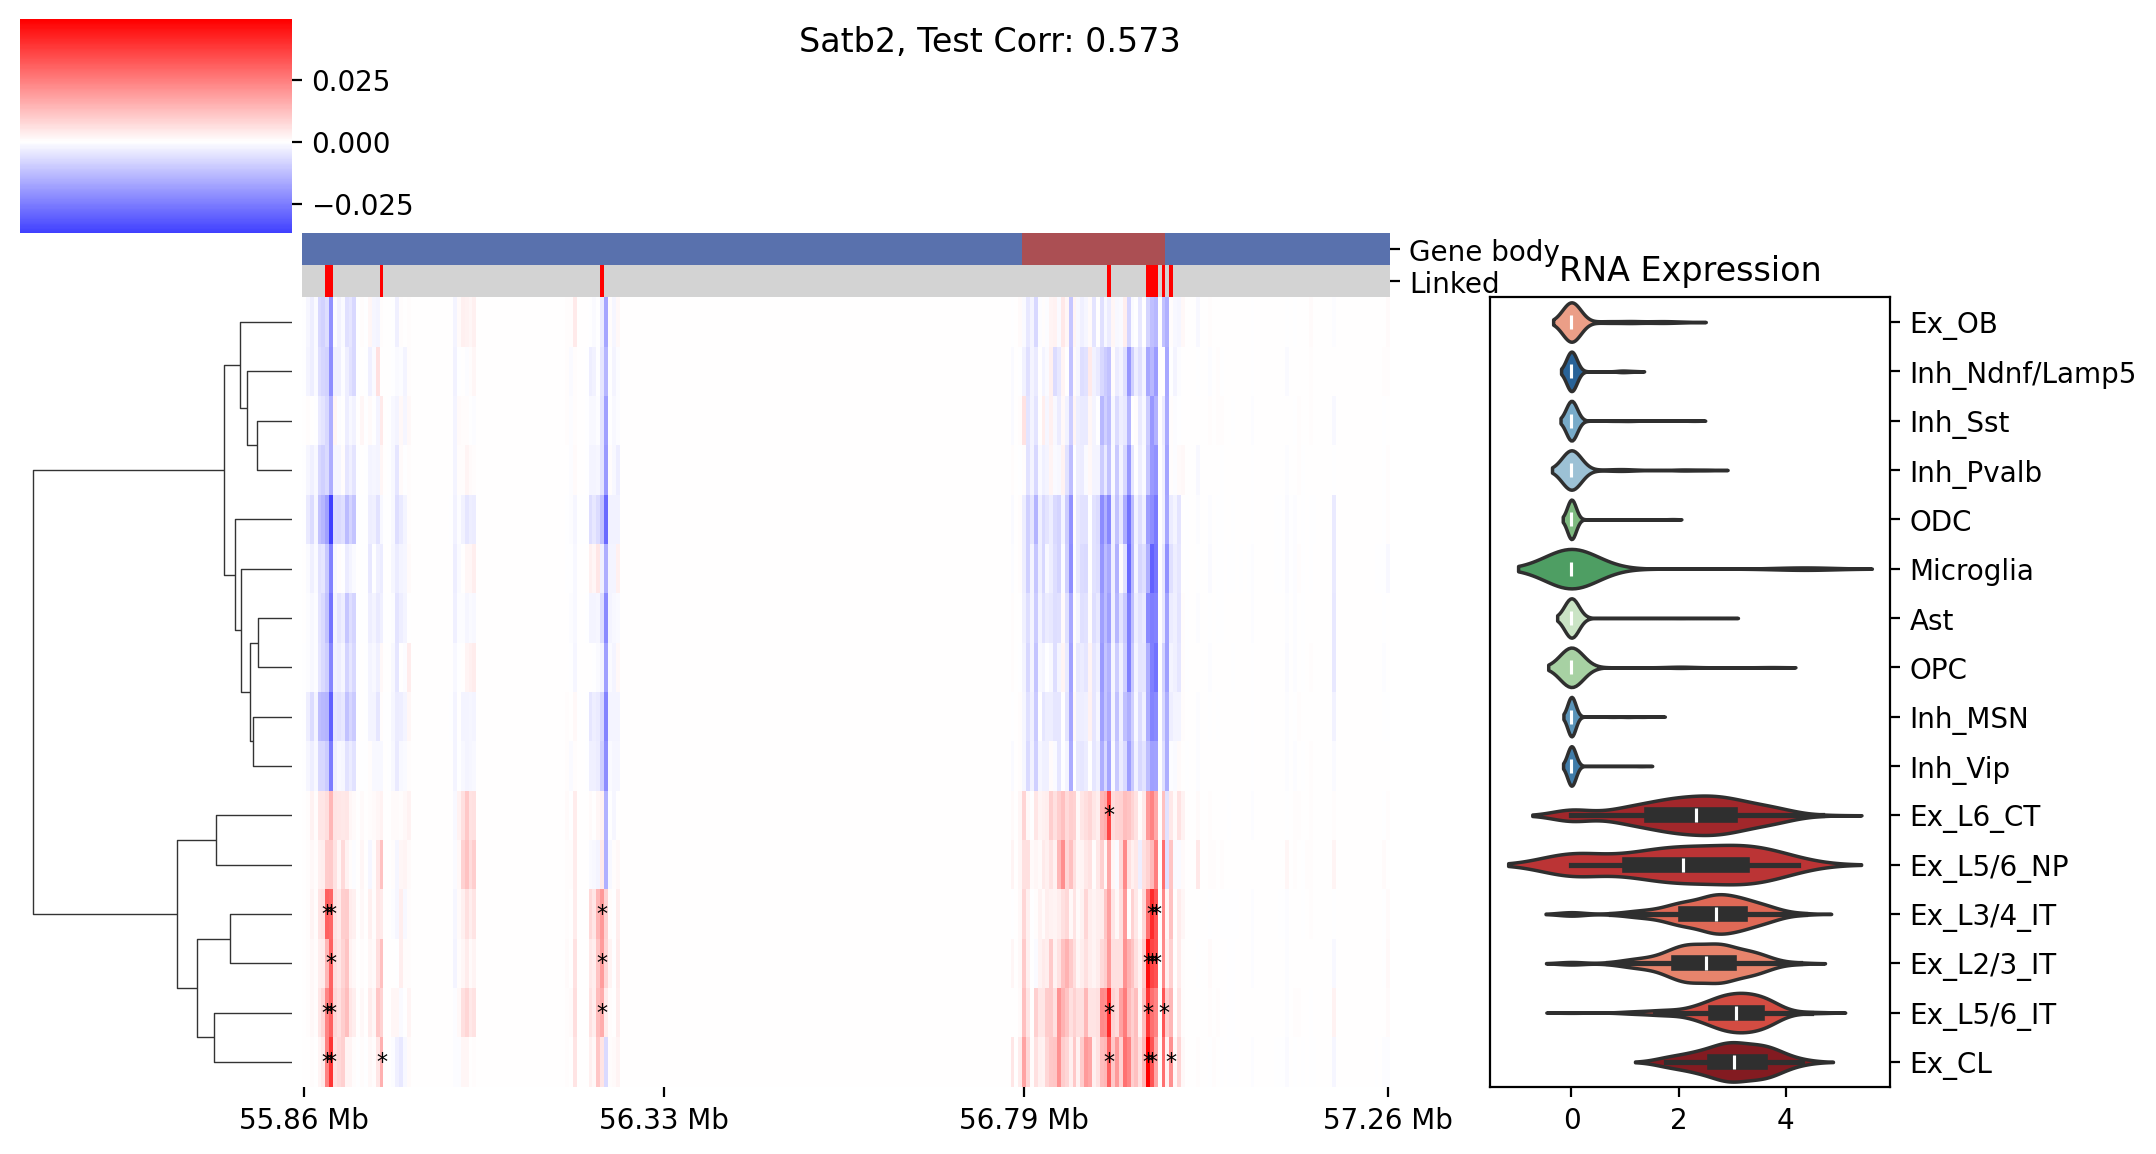

In [11]:
shap_threshod = 0.015

rna_vln_data = rnamat.loc[gene,].reset_index().rename(columns={"index": "cellname"}).merge(metadata[["cellname","celltype"]], on="cellname").set_index("cellname")
chorm = genes.query('name == @gene')["chrom"].values[0]
start = genes.query('name == @gene')["start"].values[0]
end = genes.query('name == @gene')["end"].values[0]
annotate_df = pd.DataFrame(total_shap.T.index).rename(columns={0:"pos"})
annotate_df["within_gene"] = annotate_df["pos"].apply(lambda x: True if start <= x <= end else False)
annotate_df["category"] = annotate_df["within_gene"].map({True: "Within Gene", False: "Intergenic"})
palette = {"Within Gene": "#ab4f53", "Intergenic": "#5971ad"}
lut = dict(zip(annotate_df["pos"], annotate_df["category"]))
category_colors = total_shap.columns.to_series().map(lut).map(palette)
# max_threshold_colors = total_shap.max().apply(lambda x: "red" if x > shap_threshod else "lightgray")

# get threshold for genebody
vec = total_shap.loc[:,annotate_df.query('category=="Within Gene"')["pos"].values].values.reshape(1,-1)[0]
vec_positive = vec[vec > shap_threshod]
sorted_values = vec_positive[np.argsort(vec_positive)[::-1]]
sorted_values_norm = (sorted_values - np.min(sorted_values)) / (np.max(sorted_values) - np.min(sorted_values)) 
rank_order = np.arange(len(sorted_values_norm))
rank_order_norm = (rank_order - np.min(rank_order)) / (np.max(rank_order) - np.min(rank_order))
distances = np.abs(sorted_values_norm - (1 - rank_order_norm))
max_distance_idx = np.argmax(distances)
max_distance_value = sorted_values[max_distance_idx]
shap_thershold_genebody = max_distance_value

annotate_df["linked"] = total_shap.max().values
annotate_df["linked"] = annotate_df.apply(lambda x: True if x["category"] == "Within Gene" and x["linked"] > shap_thershold_genebody else (x["category"] == "Intergenic" and x["linked"] > shap_threshod), axis=1)
max_threshold_colors = annotate_df["linked"].apply(lambda x: "red" if x == True else "lightgray").values
# if category is "Within Gene"
# annotate_df["linked"] 

col_colors = pd.DataFrame({
    "Gene body": category_colors,
    "Linked": max_threshold_colors
}, index=total_shap.columns)


# cluster heatmap
g = sns.clustermap(
    total_shap, cmap="bwr",
    col_cluster=False, center=0, col_colors=col_colors,
     cbar_pos=(0.02, 0.2, 0.03, 0.15)
)
y_order_from_heatmap = g.data2d.index

g.fig.set_size_inches(10, 6) 
g.gs.update(right=0.7)

pos_heatmap = g.ax_heatmap.get_position()
ax_violin = g.fig.add_axes([0.75, pos_heatmap.y0, 0.2, pos_heatmap.height])
sns.violinplot(data=rna_vln_data, y="celltype", x=gene, scale="width",
               palette=color_dict, order=y_order_from_heatmap, ax=ax_violin) 


g.ax_heatmap.tick_params(axis='y', length=0)
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_ylabel("")
ax_violin.yaxis.tick_right()
ax_violin.set_ylabel("")
ax_violin.set_xlabel("")
ax_violin.set_title("RNA Expression")


ax_heatmap = g.ax_heatmap
reordered_df = g.data2d  
within_gene_index = annotate_df.query('category == "Within Gene"').index.values
for i in range(reordered_df.shape[0]): 
    for j in range(reordered_df.shape[1]): 
        threshold_temp = shap_threshod if j not in within_gene_index else shap_thershold_genebody
        if reordered_df.iloc[i, j] > threshold_temp:
            ax_heatmap.text(j + 0.5, i + 0.5, "*",
                            ha='center', va='center',
                            color='black', fontsize=8)
            
num_labels = 4
total_cols = total_shap.shape[1]
xtick_locs = np.linspace(0, total_cols - 1, num_labels, dtype=int)
xtick_labels_str = total_shap.columns[xtick_locs]
xtick_labels_num = pd.to_numeric(xtick_labels_str)
bp_formatter = EngFormatter('b', places=2)
formatted_labels = [bp_formatter(x) for x in xtick_labels_num]
ax_heatmap.set_xticks(xtick_locs + 0.5)
ax_heatmap.set_xticklabels(formatted_labels, rotation=0)


g.fig.suptitle(f"{gene}, Test Corr: {results['test_corr']:.3f}")
# plt.show()
# plt.close(g.fig)

# save
g.fig.savefig(f"brain.regression.{gene}.pdf", bbox_inches='tight')

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

Text(0, 0.5, 'SHAP Value')

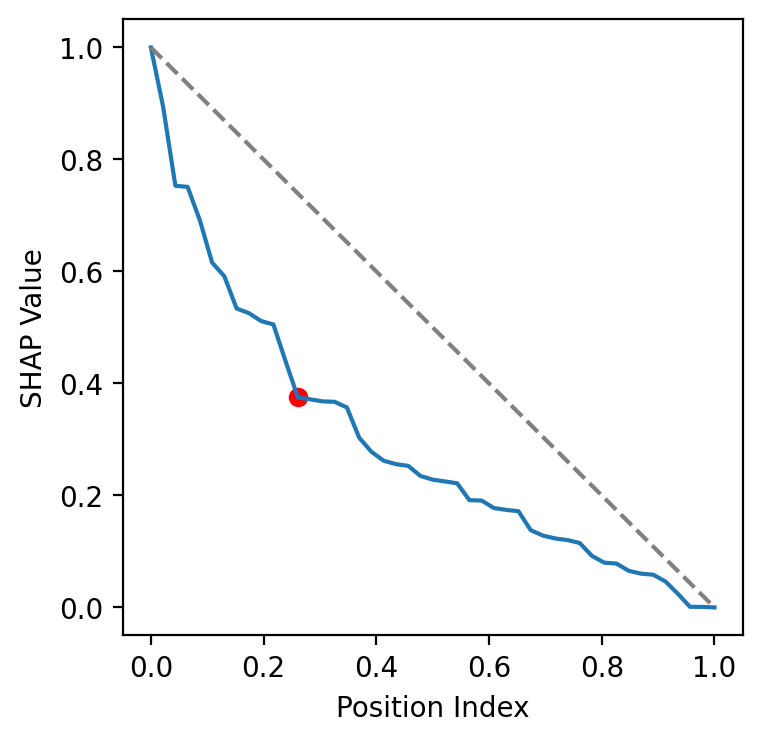

In [ ]:
plt.figure(figsize=(4, 4))

plt.plot(rank_order_norm,sorted_values_norm)
plt.plot(rank_order_norm, 1 - rank_order_norm, linestyle='--', color='gray')
plt.scatter(rank_order_norm[max_distance_idx], sorted_values_norm[max_distance_idx], color='red', label='Max Distance Point')

plt.xlabel("Position Index")
plt.ylabel("SHAP Value")

## Calc and plot for all var genes

In [ ]:
def _plot_gene(gene):
    try:
        set_all_seeds(42)
        regressor = regression.GeneRegressor(alpha=0.1, patience=20, norm_type="l2")
        X, y, bins_considered = _load_regression_data(gene)
        model, results = regressor.train_test_model(X= X, y=y, epochs=1000, test_size=0.2, lr=1e-3, batch_size=16, patience=20,celltype=metadata["celltype"].values)
        shap_lst, shap_d = regression.set_gene_tile_significance_bootstrapped(X, y, model.linear.weight.data.numpy(), model.linear.bias.data.numpy(), metadata, "celltype", metadata["celltype"].unique())

        #if results["test_corr"] > 0.1:

        atac_shap = pd.DataFrame(shap_d).T.iloc[:,:bins_considered.shape[0]]
        atac_shap.columns = bins_considered["pos"].values
        ct_shap = pd.DataFrame(shap_d).T.iloc[:,bins_considered.shape[0]:2*bins_considered.shape[0]]
        ct_shap.columns = bins_considered["pos"].values
        contact_shap = pd.DataFrame(shap_d).T.iloc[:,2*bins_considered.shape[0]:]
        contact_shap.columns = bins_considered["pos"].values

        total_shap = atac_shap + ct_shap + contact_shap

        start_pos = bins_considered["pos"].min()
        end_pos = bins_considered["pos"].max()

        total_shap_zeros = pd.DataFrame(np.zeros((total_shap.shape[0],(end_pos-start_pos)//5000+1)))
        total_shap_zeros.columns = np.arange(start_pos,end_pos+1,5000)
        total_shap_zeros.index = total_shap.index

        total_shap = total_shap_zeros + total_shap
        total_shap = total_shap.fillna(0)

        atac_shap = total_shap_zeros + atac_shap
        atac_shap = atac_shap.fillna(0)
        ct_shap = total_shap_zeros + ct_shap
        ct_shap = ct_shap.fillna(0)
        contact_shap = total_shap_zeros + contact_shap
        contact_shap = contact_shap.fillna(0)

        ##############plot################
        shap_threshod = 0.015

        rna_vln_data = rnamat.loc[gene,].reset_index().rename(columns={"index": "cellname"}).merge(metadata[["cellname","celltype"]], on="cellname").set_index("cellname")
        chorm = genes.query('name == @gene')["chrom"].values[0]
        start = genes.query('name == @gene')["start"].values[0]
        end = genes.query('name == @gene')["end"].values[0]
        annotate_df = pd.DataFrame(total_shap.T.index).rename(columns={0:"pos"})
        annotate_df["within_gene"] = annotate_df["pos"].apply(lambda x: True if start <= x <= end else False)
        annotate_df["category"] = annotate_df["within_gene"].map({True: "Within Gene", False: "Intergenic"})
        palette = {"Within Gene": "#ab4f53", "Intergenic": "#5971ad"}
        lut = dict(zip(annotate_df["pos"], annotate_df["category"]))
        category_colors = total_shap.columns.to_series().map(lut).map(palette)

        # get threshold for genebody
        try:
            vec = total_shap.loc[:,annotate_df.query('category=="Within Gene"')["pos"].values].values.reshape(1,-1)[0]
            vec_positive = vec[vec > shap_threshod]
            sorted_values = vec_positive[np.argsort(vec_positive)[::-1]]
            sorted_values_norm = (sorted_values - np.min(sorted_values)) / (np.max(sorted_values) - np.min(sorted_values)) 
            rank_order = np.arange(len(sorted_values_norm))
            rank_order_norm = (rank_order - np.min(rank_order)) / (np.max(rank_order) - np.min(rank_order))
            distances = np.abs(sorted_values_norm - (1 - rank_order_norm))
            max_distance_idx = np.argmax(distances)
            max_distance_value = sorted_values[max_distance_idx]
            shap_thershold_genebody = max_distance_value
        except:
            shap_thershold_genebody = shap_threshod

        annotate_df["linked"] = total_shap.max().values
        annotate_df["linked"] = annotate_df.apply(lambda x: True if x["category"] == "Within Gene" and x["linked"] > shap_thershold_genebody else (x["category"] == "Intergenic" and x["linked"] > shap_threshod), axis=1)
        max_threshold_colors = annotate_df["linked"].apply(lambda x: "red" if x == True else "lightgray").values
        # if category is "Within Gene"
        # annotate_df["linked"] 

        col_colors = pd.DataFrame({
            "Gene body": category_colors,
            "Linked": max_threshold_colors
        }, index=total_shap.columns)


        # cluster heatmap
        g = sns.clustermap(
            total_shap, cmap="coolwarm",
            col_cluster=False, center=0, col_colors=col_colors,
            cbar_pos=(0.02, 0.2, 0.03, 0.15)
        )
        y_order_from_heatmap = g.data2d.index

        g.fig.set_size_inches(10, 6) 
        g.gs.update(right=0.7)

        pos_heatmap = g.ax_heatmap.get_position()
        ax_violin = g.fig.add_axes([0.75, pos_heatmap.y0, 0.2, pos_heatmap.height])
        sns.violinplot(data=rna_vln_data, y="celltype", x=gene,density_norm='width', #scale="width",
                    palette=color_dict, order=y_order_from_heatmap, ax=ax_violin,hue="celltype",legend=False) 


        g.ax_heatmap.tick_params(axis='y', length=0)
        g.ax_heatmap.set_yticklabels([])
        g.ax_heatmap.set_ylabel("")
        ax_violin.yaxis.tick_right()
        ax_violin.set_ylabel("")
        ax_violin.set_xlabel("")
        ax_violin.set_title("RNA Expression")


        ax_heatmap = g.ax_heatmap
        reordered_df = g.data2d  
        within_gene_index = annotate_df.query('category == "Within Gene"').index.values
        for i in range(reordered_df.shape[0]): 
            for j in range(reordered_df.shape[1]): 
                threshold_temp = shap_threshod if j not in within_gene_index else shap_thershold_genebody
                if reordered_df.iloc[i, j] > threshold_temp:
                    ax_heatmap.text(j + 0.5, i + 0.5, "*",
                                    ha='center', va='center',
                                    color='black', fontsize=8)
                    
        num_labels = 4
        total_cols = total_shap.shape[1]
        xtick_locs = np.linspace(0, total_cols - 1, num_labels, dtype=int)
        xtick_labels_str = total_shap.columns[xtick_locs]
        xtick_labels_num = pd.to_numeric(xtick_labels_str)
        bp_formatter = EngFormatter('b', places=2)
        formatted_labels = [bp_formatter(x) for x in xtick_labels_num]
        ax_heatmap.set_xticks(xtick_locs + 0.5)
        ax_heatmap.set_xticklabels(formatted_labels, rotation=0)


        pc1expratio = PCA(n_components=2).fit(total_shap.values).explained_variance_ratio_[0]
        g.fig.suptitle(f"{gene}, Test Corr: {results['test_corr']:.3f}, PC1 Var Ratio: {pc1expratio:.3f}")
        ##################################

        plt.savefig(f"./shap_plots/{gene}_shap_clustermap.pdf", bbox_inches='tight', dpi=300)
        plt.close(g.fig)

        return [gene,total_shap,atac_shap,ct_shap,contact_shap,annotate_df,pc1expratio,results['test_corr'],shap_thershold_genebody,results["celltype_corr"],results["test_pv"],results["celltype_pv"],results["shuffle_corr"],results["shuffle_pv"]]
        # else:
        #     return None
    except:
        print(gene)
        return None

In [ ]:
results = Parallel(n_jobs=200)(delayed(_plot_gene)(gene) for gene in tqdm.tqdm(variable_genes, desc="Processing genes"))

Processing genes:  10%|█         | 200/2000 [00:21<01:29, 20.05it/s]/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/s

Prdm16


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is 

Agmo


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Dscam


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Folh1
Col14a1
Prrx1
A330049N07Rik


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
Processing genes:  30%|███       | 600/2000 [01:25<03:53,  5.99it/s]/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/s

Lama2


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Emx2os


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


A230001M10Rik


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is 

Nrp1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Ndnf


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Runx1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Fli1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
Processing genes:  40%|████      | 800/2000 [02:05<03:34,  5.59it/s]/t

Gm19299


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


9630002D21Rik
Gm3985


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Gm20752


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarnin

Stard13
Itih5


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
Processing genes:  50%|█████     | 1000/2000 [02:40<02:58,  5.62it/s]/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/

Pde1b


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scip

Gm40663


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56:

B3galt5


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Gabrg1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Atp13a5
Ppara
C030029H02Rik


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An in

Nim1k


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Impg1


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


mt-Nd2


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:478

Myt1
Drd3
Pappa


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


5033421B08Rik


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scip

Fgf10


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Gm42906


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Tbxas1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Has2os


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Aass


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Mid1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is 

Trp63


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Atp7a


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scip

Gm816


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:478

mt-Rnr2


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Hapln1


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Wls


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Pla2g4a


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scip

mt-Rnr1
mt-Nd5


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Itgbl1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarnin

Cpm


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Pcp4


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56:

Itgb8


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Enox2


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: Ru

4930420G21Rik
Lgr5


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Alpk1


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scip

Gm12068


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Gm49948
Pappa2


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
Processing genes:  80%|████████  | 1600/2000 [04:29<01:11,  5.57it/s]/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/

Grap2


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarnin

Grk5


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

9330158H04Rik
Agl


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Gm48606


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An in

Kcnj16
Tmtc4


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is 

Ccnd1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
Processing genes:  90%|█████████ | 1800/2000 [05:04<00:35,  5.59it/s]/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/sit

Gm14015


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Tmtc1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Cldn10


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; t

Tmem196


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Efemp1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


mt-Cytb


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Stat3


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Gm19585


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Ets1
Scn7a


Processing genes: 100%|██████████| 2000/2000 [05:37<00:00,  5.93it/s]
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Cftr


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Gm45904


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Abca8a


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Gm13481


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


mt-Co1


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Slco2b1


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Ldlr


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scip

Hmgcs1


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is 

Cyb5d2


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torc

Ggact


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib

Gm33906


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

Gm10718


/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:478

Bace2


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide


Slc26a11


/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:58: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_2521756/2918177608.py:56: RuntimeWarning: invalid value

In [ ]:
# remove None in resultes
results = [res for res in results if res is not None]

In [ ]:
shap_metadata = []
for res in results:
    shap_metadata.append([res[0],res[6],res[7], res[8],res[9],res[10],res[11],res[12],res[13]])
shap_metadata = pd.DataFrame(shap_metadata)
shap_metadata.columns = ["gene","pc1expratio","testcorr","shap_thershold_genebody","celltype_corr","test_pv","celltype_pv","shuffle_corr","shuffle_pv"]
shap_metadata["test_fdr"] = statsmodels.stats.multitest.fdrcorrection(shap_metadata["test_pv"].values)[1]

In [ ]:
genes_keep = shap_metadata.query('test_fdr < 0.05')["gene"].values

In [ ]:
genes_keep.shape

(1462,)

In [ ]:
shap_metadata.to_csv("shap_metadata.tsv",sep="\t",index=None)

In [ ]:
atac_shap_dfs = []
ct_shap_dfs = []
contact_shap_dfs = []
total_shap_dfs = []

for res in results:
    gene_name = res[0]
    temp_df = pd.concat([res[1].T.reset_index(drop=True),res[5]],axis=1).query('linked == True')
    temp_df["gene"] = gene_name
    total_shap_dfs.append(temp_df)

    temp_df = pd.concat([res[2].T.reset_index(drop=True),res[5]],axis=1).query('linked == True')
    temp_df["gene"] = gene_name
    atac_shap_dfs.append(temp_df)

    temp_df = pd.concat([res[3].T.reset_index(drop=True),res[5]],axis=1).query('linked == True')
    temp_df["gene"] = gene_name
    ct_shap_dfs.append(temp_df)

    temp_df = pd.concat([res[4].T.reset_index(drop=True),res[5]],axis=1).query('linked == True')
    temp_df["gene"] = gene_name
    contact_shap_dfs.append(temp_df)


In [ ]:
pd.concat(total_shap_dfs).query('gene in @genes_keep').to_csv("./CHARM_cor_filter_distance_shap.tsv.gz",sep="\t",index=None)
pd.concat(atac_shap_dfs).query('gene in @genes_keep').to_csv("./CHARM_cor_filter_distance_atac_shap.tsv.gz",sep="\t",index=None)
pd.concat(ct_shap_dfs).query('gene in @genes_keep').to_csv("./CHARM_cor_filter_distance_ct_shap.tsv.gz",sep="\t",index=None)
pd.concat(contact_shap_dfs).query('gene in @genes_keep').to_csv("./CHARM_cor_filter_distance_contact_shap.tsv.gz",sep="\t",index=None)

## Multi-omics data gives better expression prediction

In [ ]:
def _calc_test_corr(gene):
    try:
        set_all_seeds(42)
        test_corr_all = {}
        test_corr_all_shuffle = {}
        test_corr_celltype_all= {}
        test_corr_all_pv = {}
        X, y, bins_considered = _load_regression_data(gene)
        feature_dim = X.shape[1] // 3
        feature_type = ["Accessibility","H3K27ac","Contact","Acc&H3K27ac","Acc&Contact","H3K27ac&Contact","Acc&H3K27ac&Contact"]
        for feature in feature_type:
            regressor = regression.GeneRegressor(alpha=0.1, patience=20, norm_type='l2')
            if feature == "Accessibility":
                X_temp = X[:,:feature_dim]
            elif feature == "H3K27ac":
                X_temp = X[:,feature_dim:2*feature_dim]
            elif feature == "Contact":
                X_temp = X[:,2*feature_dim:]
            elif feature == "Acc&H3K27ac":
                X_temp = X[:,:2*feature_dim]
            elif feature == "Acc&Contact":
                X_temp = np.hstack([X[:,:feature_dim],X[:,2*feature_dim:]])
            elif feature == "H3K27ac&Contact":
                X_temp = np.hstack([X[:,feature_dim:2*feature_dim],X[:,2*feature_dim:]])
            elif feature == "Acc&H3K27ac&Contact":
                X_temp = X

            model, result = regressor.train_test_model(X= X_temp, y=y, epochs=1000, test_size=0.2, lr=1e-3, batch_size=16, patience=20,celltype=metadata["celltype"].values)
            test_corr_all[feature] = result["test_corr"]
            test_corr_all_shuffle[feature] = result["shuffle_corr"]
            test_corr_all_pv[feature] = result["test_pv"]
            test_corr_celltype_all[feature] = result["celltype_corr"]

        return [test_corr_all,test_corr_all_shuffle,test_corr_all_pv,test_corr_celltype_all]
            
    except Exception as e:
        return None
    
temp_res = Parallel(n_jobs=200)(delayed(_calc_test_corr)(gene) for gene in tqdm.tqdm(variable_genes)) 

all_test_corrs = [res[0] for res in temp_res if res is not None]
all_test_corrs_shuffle = [res[1] for res in temp_res if res is not None]
all_test_corrs_pv = [res[2] for res in temp_res if res is not None]
all_test_corrs_celltype = [res[3] for res in temp_res if res is not None]

 10%|█         | 200/2000 [00:28<01:44, 17.31it/s]/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/share/home/zliu/min

In [ ]:
df = pd.DataFrame([x for x in all_test_corrs if x is not None])
df_shuffle = pd.DataFrame([x for x in all_test_corrs_shuffle if x is not None])
df["gene"] = [gene for idx, gene in enumerate(variable_genes) if temp_res[idx] is not None]
df_shuffle["gene"] = [gene for idx, gene in enumerate(variable_genes) if temp_res[idx] is not None]
df = df.dropna()
df_shuffle = df_shuffle.dropna()
df_pv =  pd.DataFrame([x for x in all_test_corrs_pv if x is not None])
df_pv["gene"] = [gene for idx, gene in enumerate(variable_genes) if temp_res[idx] is not None]
df_pv = df_pv.dropna()

df_celltype =  pd.DataFrame([x for x in all_test_corrs_celltype if x is not None])
df_celltype["gene"] = [gene for idx, gene in enumerate(variable_genes) if temp_res[idx] is not None]
df_celltype = df_celltype.dropna()



df.to_csv("./brain_test_corrs.tsv", sep="\t", index=False)
df_shuffle.to_csv("./brain_test_corrs_shuffle.tsv", sep="\t", index=False)
df_pv.to_csv("./brain_test_corrs_pv.tsv", sep="\t", index=False)
df_celltype.to_csv("./brain_test_corrs_celltype.tsv", sep="\t", index=False)

In [ ]:
df = pd.read_table("brain_test_corrs.tsv")
df_shuffle = pd.read_table("brain_test_corrs_shuffle.tsv")
df_pv = pd.read_table("brain_test_corrs_pv.tsv")
df_celltype = pd.read_table("brain_test_corrs_celltype.tsv")

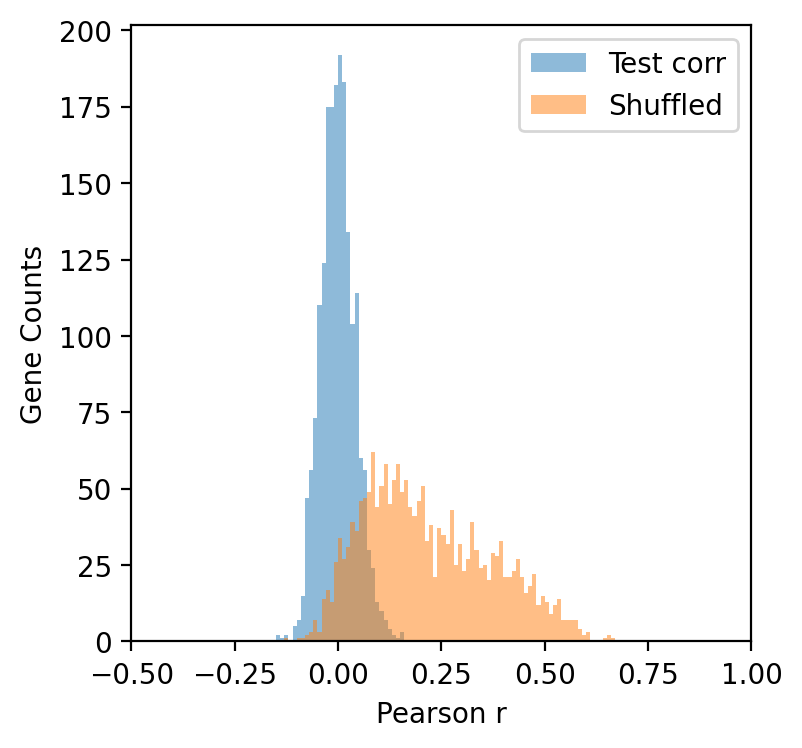

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(df_shuffle["Acc&H3K27ac&Contact"],bins=np.arange(-1,1,0.01),alpha=0.5,label="Test corr")
plt.hist(df["Acc&H3K27ac&Contact"],bins=np.arange(-1,1,0.01),alpha=0.5,label="Shuffled")

plt.xlim(-0.5,1)
#plt.axvline(0.1,linestyle="--",color="grey",label="threshold = 0.1")
plt.ylabel("Gene Counts")
plt.xlabel("Pearson r")
plt.legend()

plt.savefig("figures/brain_test_corrs_actualvsshuffle.pdf", bbox_inches='tight')

In [ ]:
df = pd.read_table("./brain_test_corrs.tsv").set_index("gene")
# drop contact column
#df = df[df.max(axis=1) > 0.1]
#df = df.query('`Acc&H3K27ac&Contact` > 0.1')
df.reset_index(inplace=True)
print(df.shape)

genes = pd.read_csv("./transcripts.bed",sep="\t",header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["length"] = genes["end"] - genes["start"]

(1911, 8)


In [ ]:
rna_sum = rnamat.sum(axis=1).reset_index()
rna_sum.columns = ["gene","sum"]
pdata = df.merge(genes[["name","length"]], left_on="gene", right_on="name", how="left").drop(columns=["name"])

# split the length in to groups: 0-50kb, 50-100kb 100-200kb 200-400kb, more than 400kb
pdata["length_group"] = pd.cut(pdata["length"], bins=[0, 50000, 100000, 200000, 400000, np.inf], labels=["0-50kb", "50-100kb", "100-200kb", "200-400kb", ">400kb"])

# equaly split into 5 var groups by rank
pdata["var_rank"] = -pdata.index
pdata["var_group"] = pd.qcut(pdata["var_rank"], q=5, labels = ["q5", "q4", "q3", "q2", "q1"])

pdata = pdata.merge(rna_sum, on="gene", how="left")
pdata["genesum_group"] = pd.qcut(pdata["sum"], q=5, labels=["q5", "q4", "q3", "q2", "q1"])


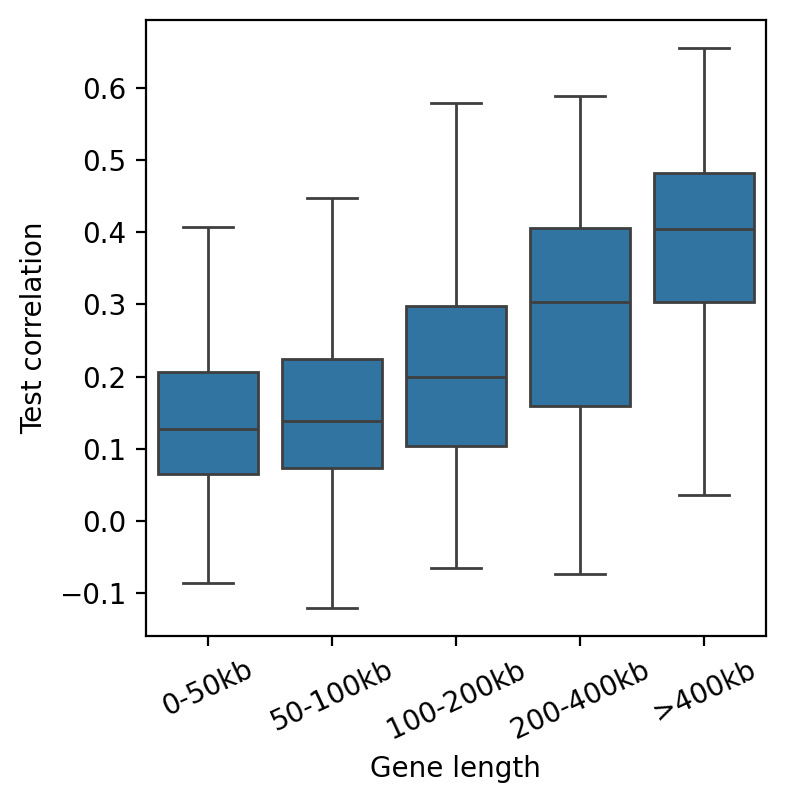

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=pdata, x="length_group", y="Acc&H3K27ac&Contact", showfliers=False)
plt.ylabel("Test correlation")
plt.xlabel("Gene length")
plt.xticks(rotation=25)
plt.savefig("figures/brain_test_corrs_length.pdf", bbox_inches='tight')

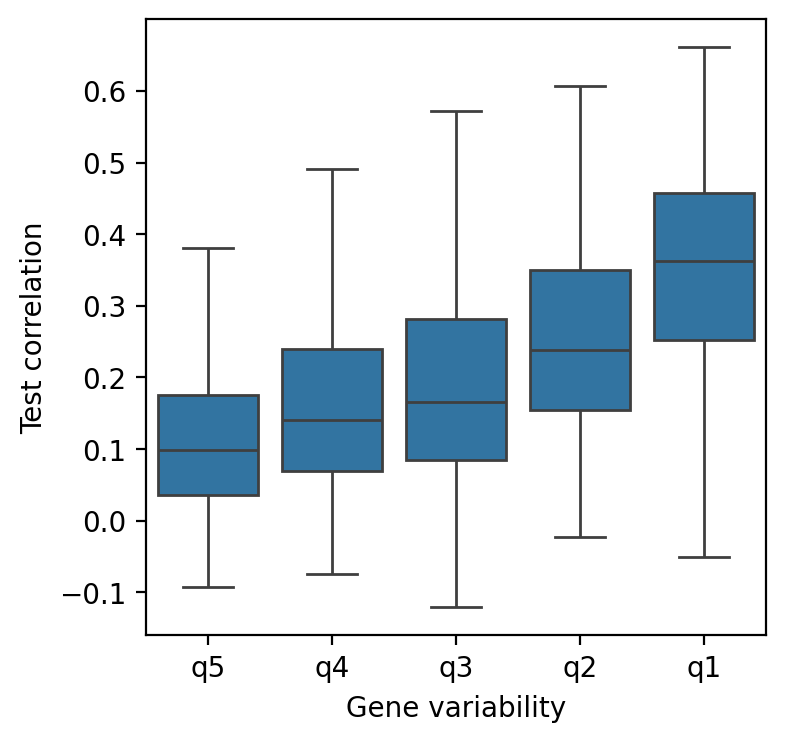

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=pdata, x="var_group", y="Acc&H3K27ac&Contact", showfliers=False)
plt.ylabel("Test correlation")
plt.xlabel("Gene variability")
plt.savefig("figures/brain_test_corrs_var.pdf", bbox_inches='tight')

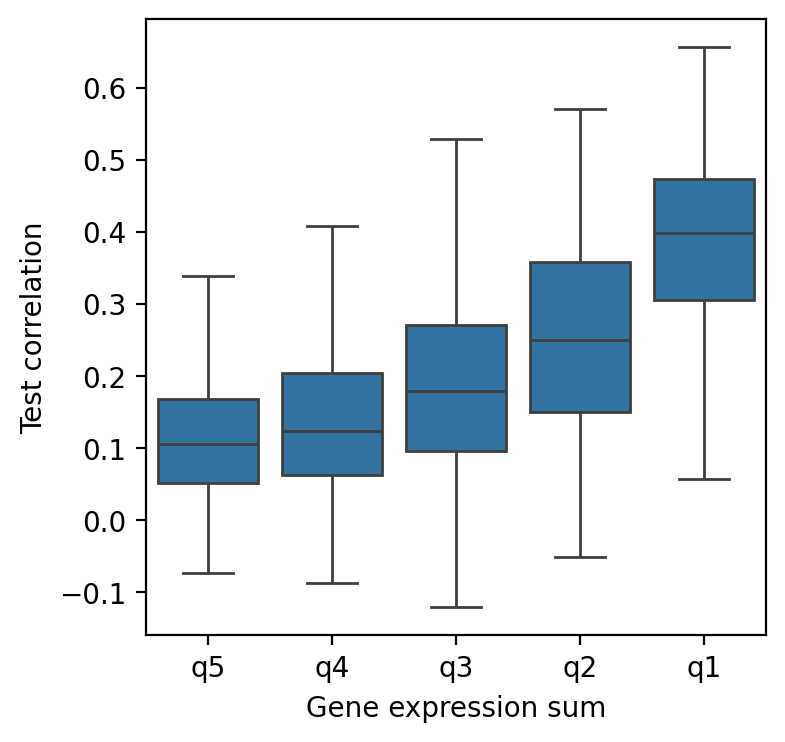

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=pdata, x="genesum_group", y="Acc&H3K27ac&Contact", showfliers=False)
plt.ylabel("Test correlation")
plt.xlabel("Gene expression sum")

plt.savefig("figures/brain_test_corrs_genesum.pdf", bbox_inches='tight')

In [ ]:
df = df.melt(var_name="feature",value_name="test_corr",id_vars="gene")
df["feature"] = pd.Categorical(df["feature"],categories=["Contact","Accessibility","Acc&Contact","H3K27ac","H3K27ac&Contact","Acc&H3K27ac","Acc&H3K27ac&Contact"])

In [ ]:
# fig = plt.figure(figsize=(4,4))
# plt.hist(df_celltype["Acc&H3K27ac&Contact"].values,bins=np.arange(-1,1,0.05),alpha=0.5,label="Celltype")
# plt.hist(df["Acc&H3K27ac&Contact"].values,bins=np.arange(-1,1,0.05),alpha=0.5,label="Single Cell")
# plt.legend()
# plt.ylabel("Counts")
# plt.xlabel("Pearson's r")
# plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accessibility vs. Acc&Contact: Wilcoxon test (paired samples), P_val:3.925e-13 Stat=7.384e+05
Acc&H3K27ac vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:1.492e-04 Stat=8.220e+05
H3K27ac&Contact vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:1.337e-156 Stat=2.703e+05
H3K27ac vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:4.397e-16 Stat=7.174e+05
Acc&Contact vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:6.437e-253 Stat=9.395e+04


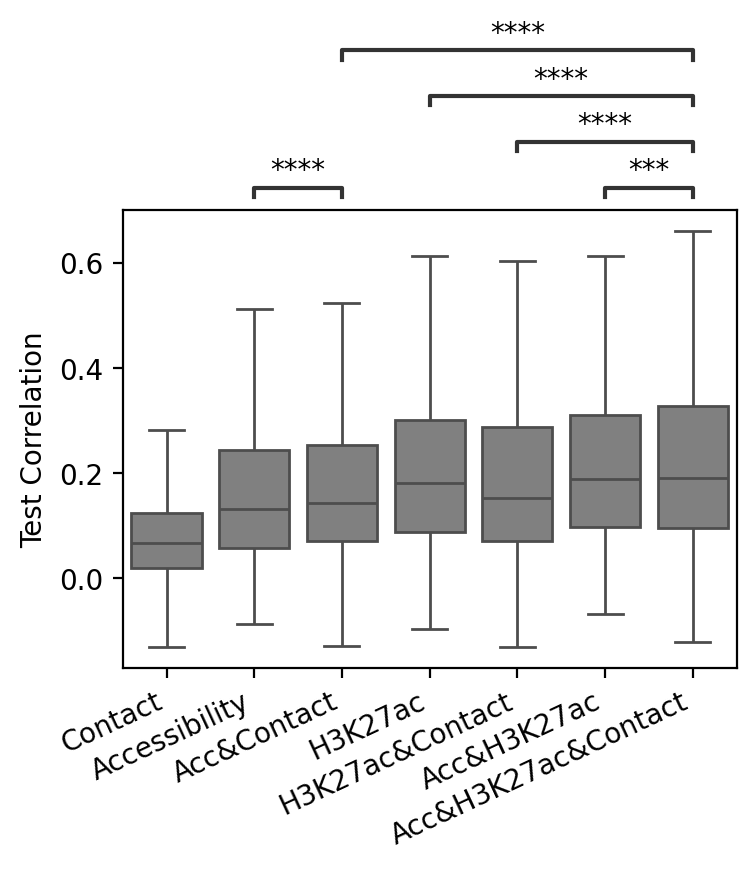

In [ ]:
plt.figure(figsize=(4,5))
ax = sns.boxplot(
    data=df,x="feature",y="test_corr",showfliers=False,color="grey",
    order= ["Contact","Accessibility","Acc&Contact","H3K27ac","H3K27ac&Contact","Acc&H3K27ac","Acc&H3K27ac&Contact"],
)

pairs = [
    ["Acc&Contact","Accessibility"],
    ["Acc&H3K27ac&Contact","H3K27ac"],
    ['Acc&H3K27ac&Contact','Acc&Contact'],
    ["Acc&H3K27ac&Contact","Acc&H3K27ac"],
    ['Acc&H3K27ac&Contact','H3K27ac&Contact'],
]

annotator = Annotator(ax, pairs,data=df,x="feature",y="test_corr")
annotator.configure(test="Wilcoxon", text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=25,ha="right")
plt.ylabel("Test Correlation")

plt.xlabel("")
plt.tight_layout()
# plt.show()
# save 
plt.savefig("figures/brain_test_corrs_boxplot.pdf", bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accessibility vs. Acc&Contact: Wilcoxon test (paired samples), P_val:3.925e-13 Stat=7.384e+05
Acc&H3K27ac vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:1.492e-04 Stat=8.220e+05
H3K27ac&Contact vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:1.337e-156 Stat=2.703e+05
H3K27ac vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:4.397e-16 Stat=7.174e+05
Acc&Contact vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:6.437e-253 Stat=9.395e+04


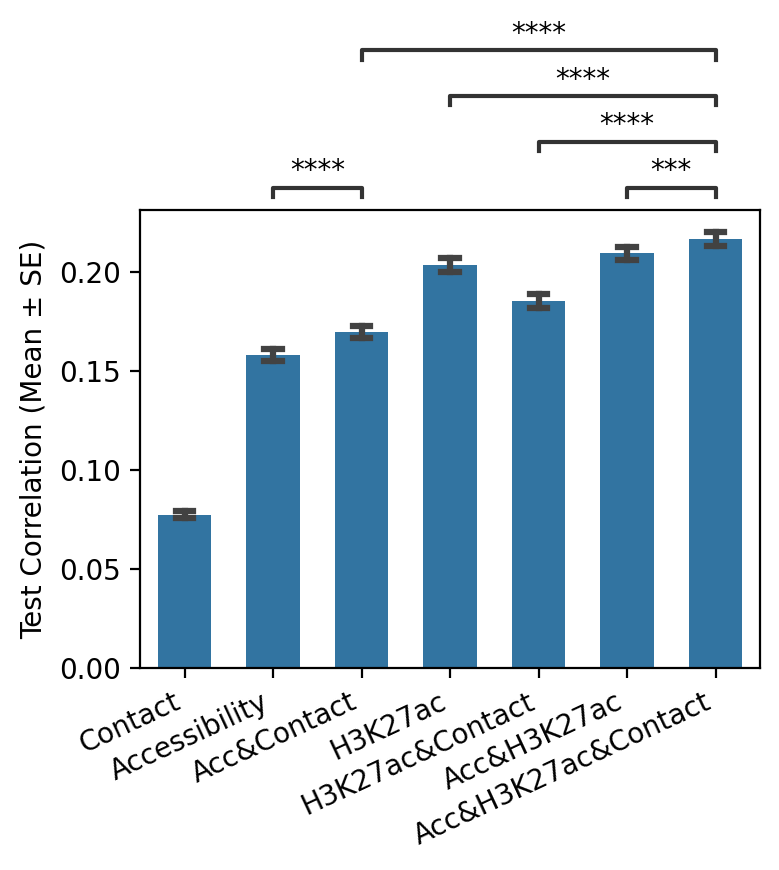

In [ ]:

plt.figure(figsize=(4,5))

ax = sns.barplot(
    data=df,
    x="feature",
    y="test_corr",
    order=["Contact", "Accessibility", "Acc&Contact", "H3K27ac", "H3K27ac&Contact", "Acc&H3K27ac", "Acc&H3K27ac&Contact"],
    errorbar='se', 
    capsize=0.2,
    width= 0.6
)
pairs = [
    ["Acc&Contact","Accessibility"],
    ["Acc&H3K27ac&Contact","H3K27ac"],
    ['Acc&H3K27ac&Contact','Acc&Contact'],
    ["Acc&H3K27ac&Contact","Acc&H3K27ac"],
    ['Acc&H3K27ac&Contact','H3K27ac&Contact'],
]
annotator = Annotator(ax, pairs, data=df, x="feature", y="test_corr")
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=25, ha="right")
plt.ylabel("Test Correlation (Mean ± SE)") 
plt.xlabel("")
plt.tight_layout()
plt.show()

In [ ]:
df.groupby("feature")["test_corr"].mean()

feature
Contact                0.077479
Accessibility          0.157973
Acc&Contact            0.169589
H3K27ac                0.203523
H3K27ac&Contact        0.185340
Acc&H3K27ac            0.209311
Acc&H3K27ac&Contact    0.216512
Name: test_corr, dtype: float64

In [ ]:
df_celltype["Acc&H3K27ac&Contact"].mean()

0.6021895721304387

In [ ]:
df_celltype.set_index("gene").mean()

Accessibility          0.417640
H3K27ac                0.592257
Contact                0.337743
Acc&H3K27ac            0.536498
Acc&Contact            0.521375
H3K27ac&Contact        0.578972
Acc&H3K27ac&Contact    0.602190
dtype: float64

In [ ]:
df_celltype = df_celltype.melt(var_name="feature",value_name="test_corr",id_vars="gene")
df_celltype["feature"] = pd.Categorical(df_celltype["feature"],categories=["Contact","Accessibility","Acc&Contact","H3K27ac","H3K27ac&Contact","Acc&H3K27ac","Acc&H3K27ac&Contact"])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accessibility vs. Acc&Contact: Wilcoxon test (paired samples), P_val:3.925e-13 Stat=7.384e+05
Acc&H3K27ac vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:1.492e-04 Stat=8.220e+05
H3K27ac&Contact vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:1.337e-156 Stat=2.703e+05
H3K27ac vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:4.397e-16 Stat=7.174e+05
Acc&Contact vs. Acc&H3K27ac&Contact: Wilcoxon test (paired samples), P_val:6.437e-253 Stat=9.395e+04


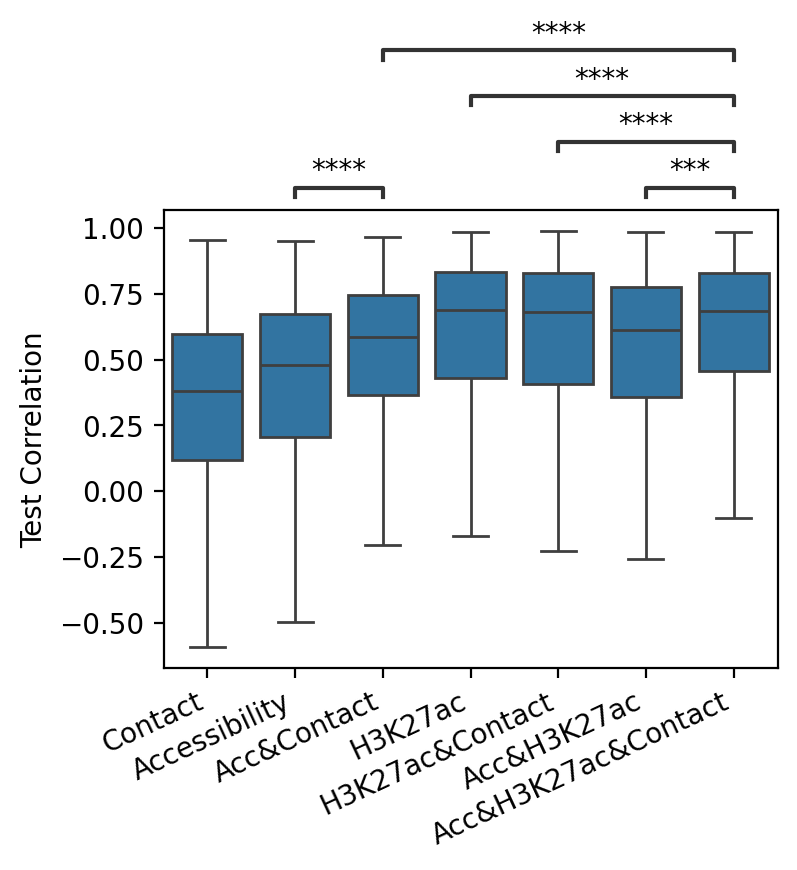

In [ ]:
plt.figure(figsize=(4,5))
ax = sns.boxplot(
    data=df_celltype,x="feature",y="test_corr",showfliers=False,
    order= ["Contact","Accessibility","Acc&Contact","H3K27ac","H3K27ac&Contact","Acc&H3K27ac","Acc&H3K27ac&Contact"],
)

pairs = [
    ["Acc&Contact","Accessibility"],
    ["Acc&H3K27ac&Contact","H3K27ac"],
    ['Acc&H3K27ac&Contact','Acc&Contact'],
    ["Acc&H3K27ac&Contact","Acc&H3K27ac"],
    ['Acc&H3K27ac&Contact','H3K27ac&Contact'],
]

annotator = Annotator(ax, pairs,data=df,x="feature",y="test_corr")
annotator.configure(test="Wilcoxon", text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=25,ha="right")
plt.ylabel("Test Correlation")

plt.xlabel("")
plt.tight_layout()
plt.show()